# Sentinel-2 `s2cloudless` high cloud probability issue after early 2022

## Load data

In [1]:
import odc.geo.xr
import datacube
from datacube.utils.masking import mask_invalid_data

from dea_tools.dask import create_local_dask_cluster
from dea_tools.plotting import display_map

dc = datacube.Datacube()

create_local_dask_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46435,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:42219,Total threads: 15
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/41191/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:35517,


In [2]:
query_params = dict(
    product=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
    x=(138.87, 138.89), 
    y=(-35.55, -35.57), 
    time=("2015", "2024")
)

load_params = dict(
    output_crs='epsg:32754',
    resolution=(-10, 10),
    group_by="solar_day",
    dask_chunks={},
    measurements=["oa_s2cloudless_prob", "oa_s2cloudless_mask", "oa_fmask"],
)


# Lazy load data
ds = dc.load(**query_params, **load_params)

# Convert -999 to NaN
ds = mask_invalid_data(ds)

# Load into memory using Dask
ds.load()

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


<xarray.Dataset> Size: 348MB
Dimensions:              (time: 512, y: 227, x: 187)
Coordinates:
  * time                 (time) datetime64[ns] 4kB 2015-11-24T00:45:11.996000...
  * y                    (y) float64 2kB 6.064e+06 6.064e+06 ... 6.062e+06
  * x                    (x) float64 1kB 3.069e+05 3.069e+05 ... 3.088e+05
    spatial_ref          int32 4B 32754
Data variables:
    oa_s2cloudless_prob  (time, y, x) float64 174MB 0.081 0.081 ... 0.885 0.885
    oa_s2cloudless_mask  (time, y, x) float32 87MB 1.0 1.0 1.0 ... 2.0 2.0 2.0
    oa_fmask             (time, y, x) float32 87MB 5.0 5.0 5.0 ... 4.0 4.0 4.0
Attributes:
    crs:           epsg:32754
    grid_mapping:  spatial_ref

Plot example timestep:

In [3]:
ds.oa_s2cloudless_prob.isel(time=-1).odc.explore()

## Compare cloudiness according to Fmask and s2cloudless

Calculate what percent of each scene is cloud (value 2) according to `Fmask`.

No hint of temporal patterns here:

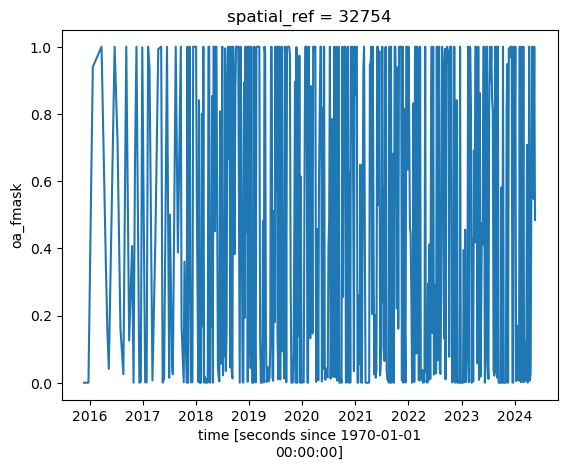

In [4]:
(ds["oa_fmask"] == 2).mean(dim=['x', 'y']).plot()

Calculate what percent of each scene is cloud (value 2) according to the `s2cloudless` mask.

Note the dramatic change from early 2022 onward: for much of this period, **most scenes have between 20-80% cloud:**

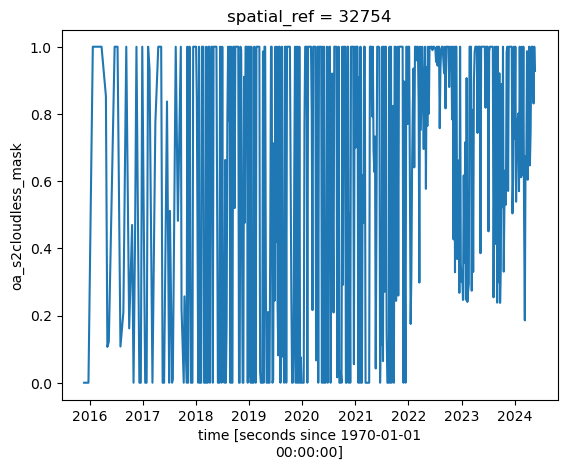

In [5]:
(ds["oa_s2cloudless_mask"] == 2).mean(dim=['x', 'y']).plot()

We can also calculate the average `s2cloudless` cloud probabilities per scene. This shows a similar pattern of **artificially high cloud probabilities early 2022:**

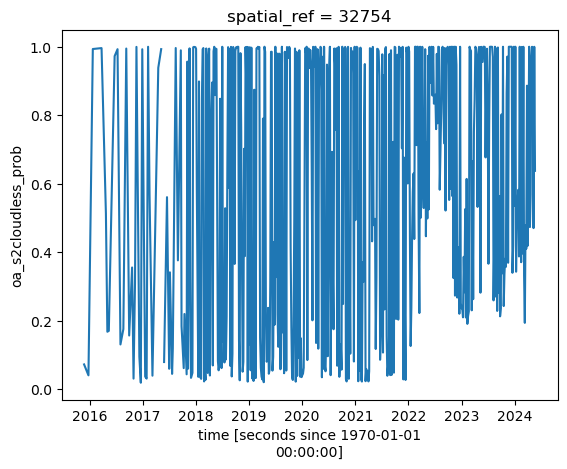

In [6]:
ds["oa_s2cloudless_prob"].mean(dim=['x', 'y']).plot()

Calculate the minimum average cloud probability per quarter to make the pattern clearer.

After early 2022, **average Sentinel-2 cloud probabilities are never less than 20%**:

/env/lib/python3.10/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


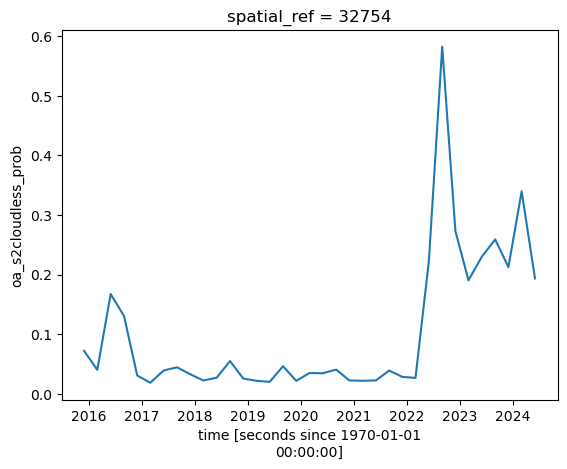

In [7]:
ds["oa_s2cloudless_prob"].mean(dim=['x', 'y']).resample(time='3M').min().plot()

## Other bands

No real evidence of similar patterns in any of the other spectral bands (only `s2cloudless`):

In [8]:
load_params = dict(
    output_crs='epsg:32754',
    resolution=(-10, 10),
    group_by="solar_day",
    dask_chunks={},
    measurements=["nbart_red", "nbart_green", "nbart_blue", "nbart_nir_1", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3"],
)

ds = dc.load(**query_params, **load_params)
ds = mask_invalid_data(ds)
ds.load()

<xarray.Dataset> Size: 609MB
Dimensions:       (time: 512, y: 227, x: 187)
Coordinates:
  * time          (time) datetime64[ns] 4kB 2015-11-24T00:45:11.996000 ... 20...
  * y             (y) float64 2kB 6.064e+06 6.064e+06 ... 6.062e+06 6.062e+06
  * x             (x) float64 1kB 3.069e+05 3.069e+05 ... 3.088e+05 3.088e+05
    spatial_ref   int32 4B 32754
Data variables:
    nbart_red     (time, y, x) float32 87MB 457.0 428.0 ... 1.89e+03 1.971e+03
    nbart_green   (time, y, x) float32 87MB 603.0 598.0 ... 2.179e+03 2.236e+03
    nbart_blue    (time, y, x) float32 87MB 491.0 473.0 ... 2.162e+03 2.212e+03
    nbart_nir_1   (time, y, x) float32 87MB 381.0 339.0 ... 1.825e+03 1.902e+03
    nbart_nir_2   (time, y, x) float32 87MB 467.0 467.0 ... 1.784e+03 1.874e+03
    nbart_swir_2  (time, y, x) float32 87MB 243.0 243.0 ... 1.606e+03 1.689e+03
    nbart_swir_3  (time, y, x) float32 87MB 156.0 156.0 ... 1.305e+03 1.368e+03
Attributes:
    crs:           epsg:32754
    grid_mapping:  spatial_ref

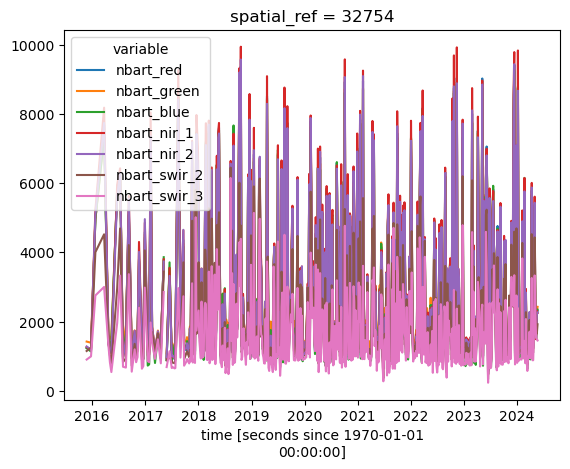

In [9]:
ds.mean(dim=['x', 'y']).to_array().plot.line(x='time');

## Theories/ideas
* **May 2024 update: seems likely to be a scaling issue in non-ARD Sentinel-2 bands (e.g. B09, B10)**
* Turbidity? But why does it respond to some flood plumes and not others?
* According to EUGL, s2cloudless is run against [Sentinel-2 Level 1C data that includes some bands (Band 9 Water Vapour, Band 10 Cirrus) that we don't include in our ARD](https://github.com/OpenDataCubePipelines/eugl/blob/master/eugl/s2cl.py#L13-L24) - could one of these bands have weird values in 2022 that explain the strange s2cloudless results?